In [17]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as tf
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import gc

In [ ]:
stat1 = torch.Tensor([0.5071, 0.4865, 0.4409])
stat2 = torch.Tensor([0.2009, 0.1984, 0.2023])
stats = stat1, stat2
stats

train_transforms = tf.Compose([
    tf.RandomHorizontalFlip(),
    tf.RandomCrop(32, padding=4, padding_mode='reflect'),
    tf.ToTensor(),
    tf.Normalize(*stats, inplace=True)
])

test_transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize(*stats)
])

train_data = CIFAR100(download=True, train=True, root="../data", transform=train_transforms)
test_data = CIFAR100(download=True, train=False, root='../data', transform=test_transforms)

In [19]:
class Bottleneck(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super().__init__()
        #"""In  our experiments, we let each 1×1 convolution
        #produce 4k feature-maps."""
        inner_channel = 4 * growth_rate

        #"""We find this design especially effective for DenseNet and
        #we refer to our network with such a bottleneck layer, i.e.,
        #to the BN-ReLU-Conv(1×1)-BN-ReLU-Conv(3×3) version of H ` ,
        #as DenseNet-B."""
        self.bottle_neck = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels, inner_channel, kernel_size=1, bias=False),
            nn.BatchNorm2d(inner_channel),
            nn.ReLU(inplace=True),
            nn.Conv2d(inner_channel, growth_rate, kernel_size=3, padding=1, bias=False)
        )

    def forward(self, x):
        return torch.cat([x, self.bottle_neck(x)], 1)

In [20]:
#"""We refer to layers between blocks as transition
#layers, which do convolution and pooling."""
class Transition(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        #"""The transition layers used in our experiments
        #consist of a batch normalization layer and an 1×1
        #convolutional layer followed by a 2×2 average pooling
        #layer""".
        self.down_sample = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.AvgPool2d(2, stride=2)
        )

    def forward(self, x):
        temp = self.down_sample(x)
        return temp

    #outputs
    """
    transition = Transition(8,4)
    example = torch.randn(1,8,32,32)
    transition(example)
    >>>
        x shape torch.Size([1, 8, 32, 32])
        after Transition(x) shape torch.Size([1, 4, 16, 16])"""



<h3><u><b><i>model : DenseNet

In [21]:
#DesneNet-BC
#B stands for bottleneck layer(BN-RELU-CONV(1x1)-BN-RELU-CONV(3x3))
#C stands for compression factor(0<=theta<=1)
class DenseNet(nn.Module):
    def __init__(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100):
        super().__init__()
        self.growth_rate = growth_rate

        #"""Before entering the first dense block, a convolution
        #with 16 (or twice the growth rate for DenseNet-BC)
        #output channels is performed on the input images."""
        inner_channels = 2 * growth_rate

        #For convolutional layers with kernel size 3×3, each
        #side of the inputs is zero-padded by one pixel to keep
        #the feature-map size fixed.
        self.conv1 = nn.Conv2d(3, inner_channels, kernel_size=3, padding=1, bias=False)

        self.features = nn.Sequential()

        for index in range(len(nblocks) - 1):
            self.features.add_module("dense_block_layer_{}".format(index), self._make_dense_layers(block, inner_channels, nblocks[index]))
            inner_channels += growth_rate * nblocks[index]

            out_channels = int(reduction * inner_channels) # int() will automatic floor the value
            self.features.add_module("transition_layer_{}".format(index), Transition(inner_channels, out_channels))
            inner_channels = out_channels

        self.features.add_module("dense_block{}".format(len(nblocks) - 1), self._make_dense_layers(block, inner_channels, nblocks[len(nblocks)-1]))
        inner_channels += growth_rate * nblocks[len(nblocks) - 1]
        self.features.add_module('bn', nn.BatchNorm2d(inner_channels))
        self.features.add_module('relu', nn.ReLU(inplace=True))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.linear_fully_connected = nn.Linear(inner_channels, num_class)

    def forward(self, x):
        #print('first data', x.shape)
        output = self.conv1(x)
        #print('after first conv', output.shape)
        output = self.features(output)
        #print('after features: all blocks', output.shape)
        output = self.avgpool(output)
        #print('after avgpool(1,1)', output.shape)
        output = output.view(output.size()[0], -1)
        #print('after view(batch_size, -1)', output.shape)
        output = self.linear_fully_connected(output)
        #print('after fully connected layer1', output.shape)
        return output

    def _make_dense_layers(self, block, in_channels, nblocks):
        dense_block = nn.Sequential()
        for index in range(nblocks):
            dense_block.add_module('bottle_neck_layer_{}'.format(index), block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return dense_block

def densenet121():
    return DenseNet(Bottleneck, [6,12,24,16], growth_rate=32)

def densenet169():
    return DenseNet(Bottleneck, [6,12,32,32], growth_rate=32)

def densenet201():
    return DenseNet(Bottleneck, [6,12,48,32], growth_rate=32)

def densenet161():
    return DenseNet(Bottleneck, [6,12,36,24], growth_rate=48)

#I tried to spread whole layers..! I hope It helps you to understand DenseNet structure.

'''densenet 121''' 
'''total 121 Layers = (6+12+24+16) * 2 + 3(transition_layer) +1(first_conv) + 1(classifying layer) '''
#bn, relu are omitted
    #conv1(3, growth_rate * 2) : channel: 3 -> 64
        #data: Tensor([batch, 64, 32, 32])

    #layer1
        #_make_dense_layers(Bottleneck, 64, 6)
        #for index in range(6):
            #block1
            #Bottleneckf(64, 32)
            #in_channels = 64 + 32 = 96
            #block2
            #Bottleneck(96, 32)
            #in_channels = 96 + 32 = 108
            #           ...
            #           ...
            # features has 6 blocks, 13 layers now, inchannels is 64 + 32 * 6 = 256!

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 128, 16, 16])
            #in_channel = 128 

    #layer2
        #_make_dense_layers(Bottleneck, 128, 12)
        #for index in range(12):
            #block1
            #Bottleneckf(128, 32)
            #in_channels = 128 + 32 = 160
            #block2
            #Bottleneck(160, 32)
            #in_channels = 160 + 32 = 192
            #           ...
            #           ...
            # features has 18 blocks 37 layers now, inchannels is 128 + 32 * 12 = 512

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 256, 8, 8])
            #in_channel = 256
    
    #layer3
        #_make_dense_layers(Bottleneck, 256, 24)
        #for index in range(24):
            #block1
            #Bottleneckf(256, 32)
            #in_channels = 256 + 32 = 288
            #           ...
            #           ...
            # features has 42 blocks 85 layers now, inchannels is 256 + 32 * 24 = 1024

        #transition layer Transition(in_channels, out_channels = in_channels * 0.5)
            #data became Tensor([batch, 512, 4, 4])
            #in_channel = 512

    #layer4
        #_make_dense_layers(Bottleneck, 512, 16)
        #for index in range(16):
            #           ...
            #           ...
            # features has 58 blocks 117 layers now, inchannels is 512 + 32 * 16 = 1024

        
            #data became Tensor([batch, 1024, 4, 4])
            #in_channel = 1024

    #nn.AdaptiveAvgPool2d((1, 1))
        #data Tensor([batch, 1024, 1, 1])

    #view(batch_size, -1)
        #data Tensor([batch, 1024 * 4* 4])

    #fully_connected_layer
        #data Tensor([batch, 100])


<h4><b><u> Test model!!!

In [ ]:
model_for_test = densenet121()
example = torch.randn(1, 3, 32, 32)
model_for_test(example)

''' 
densenet 121  Total 121 layers!!!
'''

"""
first data torch.Size([1, 3, 32, 32])
after first conv torch.Size([1, 64, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 96, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 128, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 160, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 192, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 224, 32, 32])
after concatenate x and bottleneck(x) shape torch.Size([1, 256, 32, 32])
after Transition(x) shape torch.Size([1, 128, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 160, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 192, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 224, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 256, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 288, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 320, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 352, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 384, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 416, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 448, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 480, 16, 16])
after concatenate x and bottleneck(x) shape torch.Size([1, 512, 16, 16])
after Transition(x) shape torch.Size([1, 256, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 288, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 320, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 352, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 384, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 416, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 448, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 480, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 512, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 544, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 576, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 608, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 640, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 672, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 704, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 736, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 768, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 800, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 832, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 864, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 896, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 928, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 960, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 992, 8, 8])
after concatenate x and bottleneck(x) shape torch.Size([1, 1024, 8, 8])
after Transition(x) shape torch.Size([1, 512, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 544, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 576, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 608, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 640, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 672, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 704, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 736, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 768, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 800, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 832, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 864, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 896, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 928, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 960, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 992, 4, 4])
after concatenate x and bottleneck(x) shape torch.Size([1, 1024, 4, 4])
after features: all blocks torch.Size([1, 1024, 4, 4])
after avgpool(1,1) torch.Size([1, 1024, 1, 1])
after view(batch_size, -1) torch.Size([1, 1024])
after fully connected layer1 torch.Size([1, 100]) """

In [12]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
def train_model(_model, _epoch, _train_data_loader, _optimizer, _lr_sche, _creterion, _array_cost, _array_accu, _array_lr):
    train_cost_sum = 0
    corrects = 0
    print('----------------train----------------')
    for batch_idx, data in enumerate(_train_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)

        _optimizer.zero_grad()
        prediction = _model(x)
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = creterion(prediction, y)
        cost.backward()
        _optimizer.step()
        _lr_sche.step()
        _array_lr.append(get_lr(_optimizer))


        train_cost_sum += cost.item()
        if (batch_idx + 1) % (len(_train_data_loader)//3) == 0:
            train_cost_avg = train_cost_sum / (batch_idx + 1)
            print('Epoch:{:2d}/{} batch_idx:{:3d} Train Cost:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, train_cost_avg))
    
    #_lr_sche.step()
    accuracy = (corrects / len(train_data))*100
    print('Epoch:{:2d}/{} batch_idx:{:3d} Train Accuracy:{:2.6f}'
            .format(_epoch, TRAIN_EPOCHS, batch_idx, accuracy))
    _array_cost.append(train_cost_sum/len(_train_data_loader))
    _array_accu.append(accuracy)
        

In [14]:
def test_model(_model, _epoch, _test_data_loader, _creterion, _array_cost, _array_accu):
    test_cost_avg = 0
    corrects = 0
    print('----------------test----------------')
    for batch_idx, data in enumerate(_test_data_loader):
        x, y = data
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        prediction = _model(x)
        
        #corrects_tenser = (prediction.argmax(1) == y)
        #print('corrects shape', corrects_tenser.shape)
        
        corrects += (prediction.argmax(1) == y).sum().item()
        cost = _creterion(prediction, y)
        test_cost_avg += cost.item()/len(_test_data_loader)

    accuracy = (corrects / len(test_data)) * 100
    print('Epoch:{:2d}/{} Test Cost:{:2.6f} Test Accuracy:{:.4f}'
            .format(_epoch, TRAIN_EPOCHS, test_cost_avg, accuracy))
    _array_cost.append(test_cost_avg)
    _array_accu.append(accuracy)


In [23]:
BATCH_SIZE = 72
train_data_loader = torch.utils.data.DataLoader(train_data, BATCH_SIZE, num_workers=4, pin_memory=True, shuffle=True, drop_last=True)
test_data_loader = torch.utils.data.DataLoader(test_data, BATCH_SIZE, num_workers=4, pin_memory=True)

In [24]:
print('train data set shape', len(train_data))
print('test data set shape', len(test_data))

for data in train_data_loader:
    x, y = data
    print('x shape', x.shape)
    print('y shape', y.shape)

    break
train_iteration = len(train_data)/BATCH_SIZE

print('data_loader length', len(train_data_loader))

train data set shape 50000
test data set shape 10000
x shape torch.Size([72, 3, 32, 32])
y shape torch.Size([72])
data_loader length 694


In [ ]:
DEVICE = 'cuda:0' #if you can't use GPU, edit 'cuda:0' as 'cpu'
LEARNING_RATE = 0.1
TRAIN_EPOCHS = 80
#models I've tried
# d121 = [6,12,24,16]     accu: 71.67% 
# d161 = [6,12,32,32]     accu: 70.29%
# custom = [3, 9, 18]     accu: 72.13%
# custom2 = [5, 10, 20]   accu: 71.58%
# custom3 = [4, 10, 24]   accu: 74.30% #growth_rate=24
# custom4 = [4, 10, 24]   accu: 75.71% #growth_rate=32
# custom5 = [5, 13, 27]   accu: 76.34% #growth rate=32 down below
# custom6 = [6, 15, 29]   accu: 76.24%
# custom7 = [6, 17, 29]   accu: 76.37%
# custom8 = [10, 17, 29]  accu: 76.89%
# custom9 = [12, 19, 30]  accu: 77.22%
custom10 = [15, 23, 30] # accu: 77.85% #best accuracy!
nblocks = custom10
gr = 32 
model_densenet = DenseNet(Bottleneck, nblocks, growth_rate=gr) #DenseNet(self, block, nblocks, growth_rate=12, reduction=0.5, num_class=100) 
model_densenet = model_densenet.to(DEVICE)

optimizer = optim.SGD(model_densenet.parameters(), lr=LEARNING_RATE, momentum=0.9)
lr_sche = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = LEARNING_RATE, epochs=TRAIN_EPOCHS, steps_per_epoch=len(train_data_loader))

creterion = nn.CrossEntropyLoss().to(DEVICE)

train_cost_arr = []
train_accu_arr = []
test_cost_arr = []
test_accu_arr = []
x_array = []
lr_array = []
str_blocks = '|'.join(map(str, nblocks)) #for saving model informaiton

for epoch in range(TRAIN_EPOCHS):
    x_array.append(epoch + 1)
    train_cost_sum = 0
    test_cost_avg = 0

    model_densenet.train()
    train_model(model_densenet, epoch+1, train_data_loader, optimizer, lr_sche, creterion, train_cost_arr,train_accu_arr, lr_array)
    
    model_densenet.eval()
    test_model(model_densenet, epoch+1, test_data_loader, creterion, test_cost_arr, test_accu_arr)

    '''If you use codes below you can see Train and Test COST & ACCURACY per each epoch'''
    # plt.subplot(1,2,1)
    # plt.plot(x_array, train_cost_arr, 'r', label='train cost')
    # plt.plot(x_array, test_cost_arr, 'g', label='test cost')
    # plt.xlabel('EPOCH')
    # plt.ylabel('Cost')
    # plt.title('Train(r)/Test(g) Cost vs Epoch')
    
    # plt.subplot(1,2,2)
    # plt.plot(x_array, train_accu_arr, 'r', label='train accu')
    # plt.plot(x_array, test_accu_arr, 'g', label='test accu')
    # plt.xlabel('EPOCH')
    # plt.ylabel('ACCURACY')
    # plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
    
    # plt.rcParams["figure.figsize"] = (17,5)
    # plt.rcParams['axes.grid'] = True 
    # plt.show()

    # plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
    # plt.xlabel('minibatch')
    # plt.ylabel('learning rate')
    # plt.title('learning rate vs minibatchs')
    # plt.show()

#Save model with a name that includes useful informations
torch.save(model_densenet, '../trained_models/densenet{}_epoch{}_ly{}_gr{}_accuLB{:2.2f}|{:2.2f}.pt'.format(sum(nblocks)*2 + 5 ,TRAIN_EPOCHS, str_blocks, gr, test_accu_arr[-1], max(test_accu_arr)))

#Plot graph for Learning rate!
plt.plot([x for x in range(len(lr_array))], lr_array, 'b')
plt.xlabel('minibatch')
plt.ylabel('learning rate')
plt.title('learning rate vs minibatchs')

<h4><b><u> Plot final graph

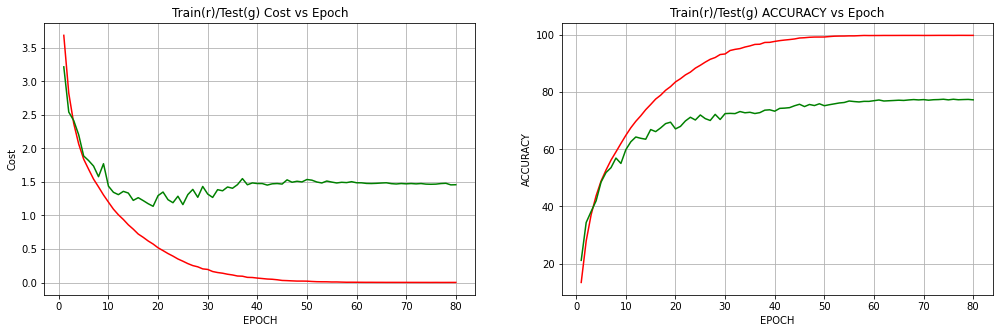

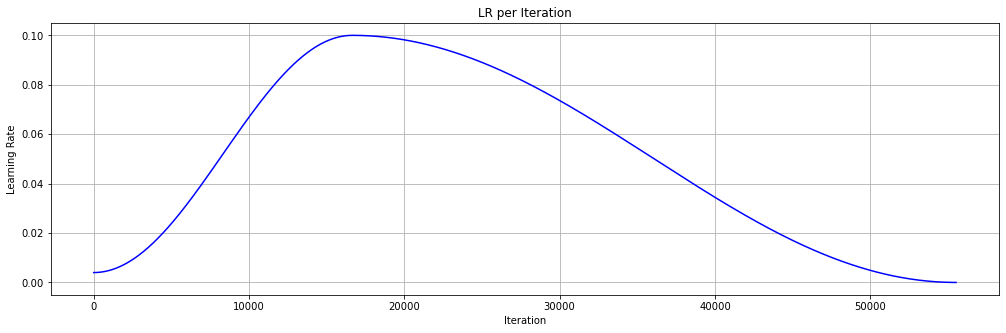

In [22]:
plt.rcParams["figure.figsize"] = (17,5)
plt.rcParams['axes.grid'] = True 

plt.subplot(1,2,1)
plt.plot(x_array, train_cost_arr, 'r', label='train cost')
plt.plot(x_array, test_cost_arr, 'g', label='test cost')
plt.xlabel('EPOCH')
plt.ylabel('Cost')
plt.title('Train(r)/Test(g) Cost vs Epoch')

plt.subplot(1,2,2)
plt.plot(x_array, train_accu_arr, 'r', label='train accu')
plt.plot(x_array, test_accu_arr, 'g', label='test accu')
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.title('Train(r)/Test(g) ACCURACY vs Epoch')
plt.show()

plt.plot([x for x in range(len(lr_array))], lr_array, 'b', label='lr per iteration')
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('LR per Iteration')
plt.show()

<h4><b><u> Testing model with no graph.

In [ ]:
#this code takes some time..! but very accurate!
DEVICE = 'cuda:0'

def test_model_no_graph(_model, _test_data, _creterion):
    corrects = 0
    _model.to(DEVICE)
    _model.eval()
    print('----------------evaluating model----------------')
    for idx, data in enumerate(_test_data):
        x, y = data
        x = x.float().to(DEVICE)
        x.unsqueeze_(0)
        prediction = _model(x)
        corrects += (prediction.argmax(1).item() == y)
        #print(corrects, '/', idx)

    return corrects/len(test_data)

model_loaded = torch.load('../trained_models/densenet141_epoch80_ly15|23|30_gr32_accuLB77.34|77.55.pt') #change model name as model stored! 
model_loaded = model_loaded.to(DEVICE)
test_accuracy = test_model_no_graph(model_loaded, test_data, creterion)
print('Test Accuracy', test_accuracy * 100, '%')

<h3> <u> <b> Clear GPU

In [44]:
#If you want clear cache, I recommand to restart kernel
#The codes below is the next best thing.

gc.collect()
torch.cuda.empty_cache()